<a href="https://colab.research.google.com/github/Ade-Henry/Housing-Prediction/blob/main/housing_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install xgboost



# importation of libary

In [19]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import ipywidgets as widgets
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error # Import root_mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
warnings.simplefilter(action="ignore", category=FutureWarning)

In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

In [21]:
def wrangle(filepath, parse_dates=["period_begin", "period_end"]):
        # Read CSV file
        df = pd.read_csv(filepath, parse_dates=parse_dates)
        # Subset data: remove outliers
        low, high = df["median_sale_price"].quantile([0.2, 0.8])
        mask_price = df["median_sale_price"].between(low, high)
        df = df[mask_price]
        # Convert 'period_begin' to datetime and set as index
        df["period_begin"] = pd.to_datetime(df["period_begin"])
        #convert "period_begin" to monthly frequency
        df["period_begin_month"] = df["period_begin"].dt.month
        # Convert "period_begin_month" to int 64
        df["period_begin_month"] = df["period_begin_month"].astype("int64")
        # Convert 'period_end' to datetime
        df["period_end"] = pd.to_datetime(df["period_end"])
        # Drop columns with more than 50% missing values
        df.drop(columns=["price_drops_mom", "price_drops_yoy", "price_drops"], inplace=True)
        # drop leakages column
        df.drop(columns=[
                       "inventory_mom",
          "inventory_yoy",
            "months_of_supply_mom",
            "months_of_supply_yoy",
            "median_dom",
            "median_dom_mom",
            "median_dom_yoy",
            "avg_sale_to_list",
            "avg_sale_to_list_mom",
            "avg_sale_to_list_yoy",
            "sold_above_list",
            "sold_above_list_mom",
            "sold_above_list_yoy",
            "off_market_in_two_weeks",
            "off_market_in_two_weeks_mom",
            "off_market_in_two_weeks_yoy",
            "parent_metro_region_metro_code",
            "last_updated",
            "period_duration",
            "region_type",
            "region_type_id",
            "table_id",
            "is_seasonally_adjusted",
            "region",
            "state_code",
            "median_sale_price_mom",
            "median_sale_price_yoy",
            "median_list_price",
            "median_list_price_mom",
            "median_list_price_yoy",
            "median_ppsf",
            "median_ppsf_mom",
            "median_ppsf_yoy",
            "median_list_ppsf",
            "median_list_ppsf_mom",
            "median_list_ppsf_yoy",
            "homes_sold_mom",
            "homes_sold_yoy",
            "pending_sales",
            "pending_sales_mom",
            "pending_sales_yoy",
            "new_listings",
            "new_listings_mom",
            "new_listings_yoy",
            ], inplace=True
        )

        return df

In [22]:
path = "/content/drive/MyDrive/data science/work 1/Connecticut_Louisiana_Real_Estate.csv"
df = wrangle(path)
# Display the first few rows of the cleaned DataFrame
df.head()

,Unnamed: 0,period_begin,period_end,city,state,property_type,property_type_id,median_sale_price,homes_sold,inventory,months_of_supply,parent_metro_region,period_begin_month
0,7,2019-08-01,2019-08-31,Carencro,Louisiana,Single Family Residential,6,190000.0,18.0,53.0,2.9,"Lafayette, LA",8
2,21,2022-06-01,2022-06-30,Stafford Springs,Connecticut,All Residential,-1,226500.0,14.0,14.0,1.0,"Hartford, CT",6
4,64,2024-12-01,2024-12-31,Meriden,Connecticut,All Residential,-1,300000.0,56.0,68.0,1.2,"New Haven, CT",12
5,100,2019-01-01,2019-01-31,Baldwin,Louisiana,All Residential,-1,140500.0,1.0,4.0,4.0,"Morgan City, LA",1
6,107,2021-01-01,2021-01-31,Oronoque,Connecticut,All Residential,-1,247500.0,12.0,14.0,1.2,"Bridgeport, CT",1


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80364 entries, 0 to 133367
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Unnamed: 0           80364 non-null  int64         
 1   period_begin         80364 non-null  datetime64[ns]
 2   period_end           80364 non-null  datetime64[ns]
 3   city                 80364 non-null  object        
 4   state                80364 non-null  object        
 5   property_type        80364 non-null  object        
 6   property_type_id     80364 non-null  int64         
 7   median_sale_price    80364 non-null  float64       
 8   homes_sold           80364 non-null  float64       
 9   inventory            68242 non-null  float64       
 10  months_of_supply     77216 non-null  float64       
 11  parent_metro_region  80364 non-null  object        
 12  period_begin_month   80364 non-null  int64         
dtypes: datetime64[ns](2), float64(4), i

In [24]:
target = "median_sale_price"
features = ["property_type","inventory","months_of_supply","parent_metro_region","period_begin_month"]
y = df[target]
X = df[features]
# Split the data into training and validation sets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
#select numerical column
numerical_cols= X_train_full.select_dtypes(include=["int64", "float64"]).columns.tolist()
#select categorical column
categorical_cols = X_train_full.select_dtypes(include=["object"]).columns.tolist()
# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [25]:
X_train.head()

,property_type,parent_metro_region,inventory,months_of_supply,period_begin_month
114778,Multi-Family (2-4 Unit),"Norwich, CT",32.0,6.4,11
7963,All Residential,"Hartford, CT",35.0,7.0,9
56019,Single Family Residential,"Houma, LA",20.0,20.0,6
118637,All Residential,"Lake Charles, LA",30.0,6.0,12
109771,All Residential,"Hartford, CT",28.0,7.0,9


# DATA PREPROCESSING

In [26]:

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# MODEL

In [27]:
model_options = [
    RandomForestRegressor(random_state=42),
    LinearRegression(),
    Ridge(),
    DecisionTreeRegressor(random_state=42),
    XGBRegressor(random_state=42)
]

for m in model_options:
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', m)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    print(f"{m.__class__.__name__} MAE: {mae:.2f}")

RandomForestRegressor MAE: 43589.52
LinearRegression MAE: 46908.46
Ridge MAE: 46907.18
DecisionTreeRegressor MAE: 49094.15
XGBRegressor MAE: 42627.42


In [28]:

# Create a pipeline with the preprocessor and XGBoost model
# This applies the preprocessing steps before training the model
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', XGBRegressor(n_estimators=1000, max_depth= 6, learning_rate=0.1, random_state=42))])

# Fit the pipeline on the training data
pipe.fit(X_train, y_train)

# Make predictions using the pipeline
preds = pipe.predict(X_valid)

# Evaluate the model
mae = mean_absolute_error(y_valid, preds)
print(f"✅ MAE: {mae:.2f}")

✅ MAE: 42164.56


# PREDICTION

In [29]:
def make_prediction(property_type, parent_metro_region,	inventory,	months_of_supply,	period_begin_month):
    data = {
    "property_type": property_type,
    "parent_metro_region": parent_metro_region,
    "inventory": inventory,
    "months_of_supply": months_of_supply,
    "period_begin_month": period_begin_month
    }
    df = pd.DataFrame(data, index=[0])
    prediction = pipe(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

# WIDGET

In [30]:
# Sample values from your training data
property_types = df['property_type'].dropna().unique().tolist()
metro_regions = df['parent_metro_region'].dropna().unique().tolist()

# Widgets
property_widget = widgets.Dropdown(options=property_types, description='Property Type:')
metro_widget = widgets.Dropdown(options=metro_regions, description='Metro Region:')
inventory_widget = widgets.FloatSlider(min=0, max=3500, step=1, value=50, description='Inventory:')
supply_widget = widgets.FloatSlider(min=0, max=12, step=0.1, value=3.5, description='Months Supply:')
month_widget = widgets.IntSlider(min=1, max=12, value=6, description='Month:')

# Prediction function
def predict_price(property_type, parent_metro_region, inventory, months_of_supply, period_begin_month):
    input_df = pd.DataFrame([{
        "property_type": property_type,
        "parent_metro_region": parent_metro_region,
        "inventory": inventory,
        "months_of_supply": months_of_supply,
        "period_begin_month": period_begin_month
    }])

    # Predict using pipeline (automatically applies encoding)
    prediction = pipe.predict(input_df)[0]

    print(f"📈 Predicted Median Sale Price: ${prediction:,.2f}")

# Display interactive widget
widgets.interact(
    predict_price,
    property_type=property_widget,
    parent_metro_region=metro_widget,
    inventory=inventory_widget,
    months_of_supply=supply_widget,
    period_begin_month=month_widget
)


📈 Predicted Median Sale Price: $172,379.23


<function __main__.predict_price(property_type, parent_metro_region, inventory, months_of_supply, period_begin_month)>

# EVALUTION

In [31]:
# Predict
y_pred = pipe.predict(X_valid)

# Evaluate
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))  # manually compute RMSE
r2 = r2_score(y_valid, y_pred)

# Print results
print(f"✅ MAE: ${mae:,.2f}")
print(f"📉 RMSE: ${rmse:,.2f}")
print(f"📈 R² Score: {r2:.3f}")



✅ MAE: $42,164.56
📉 RMSE: $52,355.20
📈 R² Score: 0.233


/tmp/ipython-input-32-3617944888.py:9: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


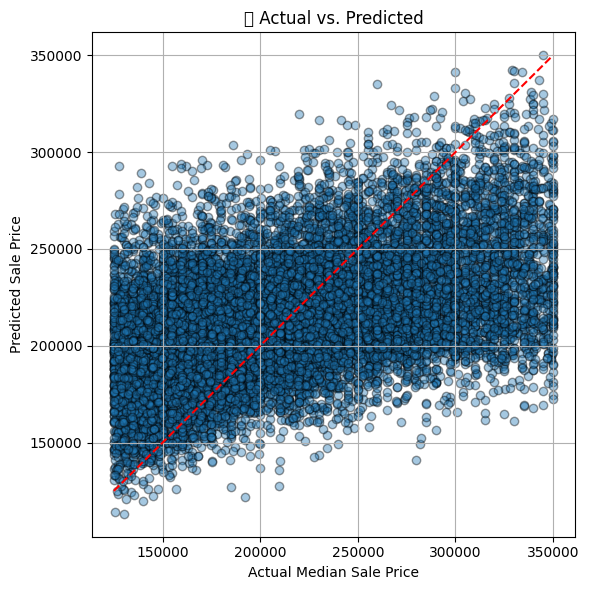

/tmp/ipython-input-32-3617944888.py:20: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


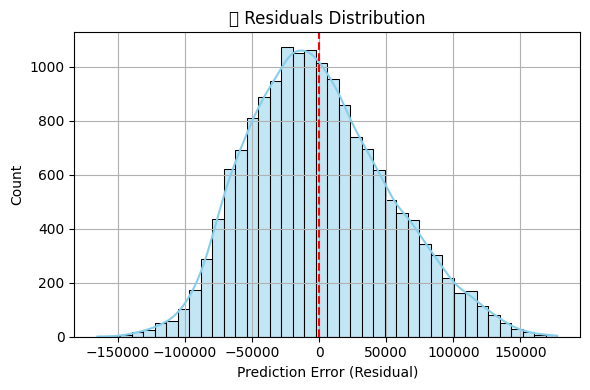

In [32]:
 # --- Chart 1: Actual vs. Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(y_valid, y_pred, alpha=0.4, edgecolor='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel("Actual Median Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("📊 Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

    # --- Chart 2: Residuals ---
residuals = y_valid - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=40, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Prediction Error (Residual)")
plt.title("📉 Residuals Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()
